# Audit Rights Investigation

**Method:**

The base features for the ‘Audit Rights’ clause are extracted from the CUAD data via the process outlined above.
For each base feature, punctuation will be removed; it will be converted to lower case; the NLTK stopwords with the addition of 'audit', 'rights', 'right', 'shall', 'record', 'records', 'books', 'book' and 'party' will be removed ; any consecutive blank spaces that number two or more will be reduced to a single space.  The token tidy process will not be applied for this clause.

The processed base features will then be vectorized using Tf-Idf vectorization, reduced to 2D via t-SNE and then clustered using KMeans clustering.  The effectiveness of the clustering will then be measured as before, and the same range of parameters investigated to find the optimal configuration.

The second investigation will encode domain knowledge in ‘hand crafted’ features.  This will utilize the knowledge that details of the notice period and how the costs of the audit will be managed are likely elements of audit rights clauses.  These are not exclusive, it is possible to have an audit rights clause without these, however they are an area that are of particular interest for this project brief and the client.

Initially, the base features are cleaned to remove double spaces and leading/trailing whitespace from the string. Every token in each cleaned base feature will then be matched (via a case insensitive match) against a words of interest list, consisting of ‘cost’ and ‘notice’. 

If a match is found, then the syntactic children of the token are identified from the feature.  These children, along with the originally matched token are appended to a list of new features for the respective contract.  If no match is found, then the string ‘noinfo’ is appended to the feature.

These new features are then processed to remove punctuation; converted to lower case; have any double spaces that have been introduced reduced to a single one; have the trailing and leading white space removed; before having the same stop words as in the provisional investigation removed. 

These new features will then be vectorized using Tf-Idf vectorization, reduced to 2D via T-SNE and then clustered using KMeans clustering.  The effectiveness of the clustering will then be measured as before, and the same range of parameters investigated to find the optimal configuration.


## Section 1: Download Data & Extract Clause Of Interest

### 1:1 Download CUAD Data

In [1]:
#Import required packages for section
from DownloadCUAD import DownloadCUAD, clean_clause
from UsefulProjectFunctions import print_samples

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RichardWarburton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Download CUAD Data to local drive
DC = DownloadCUAD()
DC.setup()

CUAD data already downloaded & extracted!


### 1.2 Extract Specific Clauses & Output Clause Text Examples

In [3]:
#Extract annotations for specific clause and the coresponding contracts 
clause_of_interest = 'Audit Rights'

#Concatenate string where there are multiple annotations.
contracts_GL,combined_annotations_GL = DC.extract_clause(clause_of_interest,True)

There are 214 contracts (41.96%) with 'Audit Rights' annotations
There are 136 contracts with more than one annotation


In [4]:
#Output m random examples of text to screen
print_samples(combined_annotations_GL)

5 Random samples from the data:

Franchisee shall be under an obligation to provide any information as may be requested by Franchisor with respect to the Smaaash Centres, including the books of accounts and other relevant documents or records maintained in relation to the Smaaash Centres. During the Term, Franchisor shall have the right to conduct audits of Franchisee with respect to the Smaaash Centres, and inspect the Smaaash Centres, after providing a written notice of 5 (five) days. 

LEA shall keep such written records respecting Cash Sales as T&B may reasonably request so that Royalty Payments payable hereunder may be accurately determined and shall permit such records to be examined by T&B or its authorized representative upon reasonable prior written notice at any reasonable time during regular business hours to verify the records, reports and payments herein provided. 

If the audit or inspection reveals that the underpayment is willful, or is for five percent (5%) or more of 

## Section 2: Pre Process Data

The following applies the pre processing outlined in the method.  This uses a bespoke transformer to allow the different elements to be toggled efficently in the pipeline

In [5]:
#Define list of additional stop words to remove in addition to XXXXXX
additional_stop_words = ['audit','rights','right','shall','record','records','books','book','party']

In [6]:
#initate clause_clean class with paramaters set for specific problem
clean = clean_clause(punct=True,
                     lower=True,
                     stop_wd = True,
                     double_spaces= True,
                     strip=True,
                     additional_stop_words = additional_stop_words)

GL_features = clean.fit_transform(combined_annotations_GL)

# Section 3: Vectorize & Clustering of Clause Data

This investigates the application of simple NLP techniques to the clause text

### Section 3.1 TfIdf Vectorisation of Clause Data with KMeans Clustering

In [7]:
#Import required packages for section
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, KMeans
from collections import defaultdict
import matplotlib.pyplot as plt
from s_dbw import S_Dbw
from collections import Counter
from UsefulProjectFunctions import label_cluster,cluster_summary

In [8]:
#Initate dictionary to hold multiple vector representations
vector_representations = {}
TSNE_representations = {}
feature_spaces = {}
vocab = {}

#Define range of n_grams to investigate
n_gram_rng =[(1,1),(1,2)]
vectorisation_technique =['TfIdf']
max_features_rng = [10,15,20,None]

for approach in vectorisation_technique:
    for n_gram in n_gram_rng:
        for feats in max_features_rng:
        
            vect_method = {'count':CountVectorizer(ngram_range = n_gram,max_features = feats),
                           'TfIdf':TfidfVectorizer(ngram_range = n_gram,max_features = feats)}

            vectorizer = vect_method[approach]
            
            
            vector_representations[(approach,n_gram,feats)] = vectorizer.fit_transform(GL_features).toarray()
            TSNE_representations[(approach,n_gram,feats)] = TSNE(n_components=2,random_state = 42).fit_transform(vector_representations[(approach,n_gram,feats)])
            vocab[(approach,n_gram,feats)] = vectorizer.vocabulary_
        

In [9]:
#Define range of cluster values (k) to investigate
k_rng = np.arange(2,16,1)

#Initate dictionaries to store results in a list
results = defaultdict(list)
score = defaultdict(list)
clustering = {}

for key in TSNE_representations.keys():
    for k in k_rng:
        cluster = KMeans(n_clusters=k, random_state=42).fit(TSNE_representations[key])
        
        #Append results for respective k to results and score lists dictionaries with given key
        results[key].append(cluster.inertia_)
        score[key].append(S_Dbw(TSNE_representations[key], cluster.labels_, centers_id=None, 
                                method='Tong', alg_noise='bind',
                                centr='mean', nearest_centr=True,
                                metric='euclidean'))

        clustering[(key,k)] = cluster
    

In [10]:
#Select Choosen Parameters (Selected in advance to aid plotting)
"""Selected in advance for formatting of plot for report"""
choosen_params =('TfIdf',(1,1),10)
choosen_k = 7

#Extract choosen plot values
x_k = choosen_k
y_sse = np.array(results[choosen_params])[k_rng == choosen_k][0]
y_sdbw = np.array(score[choosen_params])[k_rng == choosen_k][0]

In [11]:
print('SSE score for optimal paramaters: {:.2f}'.format(y_sse))
print('S-DBW score for optimal paramaters: {:.2f}'.format(y_sdbw))

SSE score for optimal paramaters: 2387.43
S-DBW score for optimal paramaters: 0.41


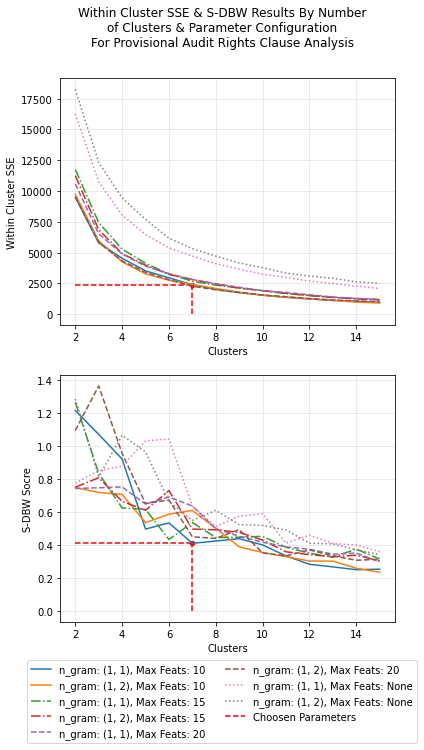

In [12]:
#Plot Results
fig, axs = plt.subplots(2, 1, figsize = (6,10))

lin_type ={10:'-',15:'-.',20:'--',None:':'}

for i in range(len(max_features_rng)):
    
    feats_to_plot = max_features_rng[i]
    
    for key in results.keys():
        if key[2] == feats_to_plot:
            
            axs[0].plot(k_rng, results[key],
                        label = 'n_gram: {1}, Max Feats: {2}'.format(*key),
                        linestyle = lin_type[feats_to_plot])
            
            axs[1].plot(k_rng, score[key],
                        label = 'n_gram: {1}, Max Feats: {2}'.format(*key),
                        linestyle = lin_type[feats_to_plot])

#Add chosen parmater call out to plot 0            
axs[0].scatter(x_k,y_sse,color = 'red',s = 20)
axs[0].vlines(x_k,ymin = 0, ymax = y_sse,color='red',linestyle='--',label ='Choosen Parameters')
axs[0].hlines(y_sse,xmin = 2, xmax = x_k,color='red',linestyle='--')

#Add chosen parmater call out to plot 1
axs[1].scatter(x_k,y_sdbw,color = 'red',s = 20)
axs[1].vlines(x_k,ymin = 0, ymax = y_sdbw,color='red',linestyle='--',label ='Choosen value')
axs[1].hlines(y_sdbw,xmin = 2, xmax = x_k,color='red',linestyle='--')


#format axs[0]            
axs[0].grid(alpha = 0.3)
axs[0].set_xlabel('Clusters')
axs[0].set_ylabel('Within Cluster SSE')

axs[1].grid(alpha = 0.3)
axs[1].set_xlabel('Clusters')
axs[1].set_ylabel('S-DBW Socre')

fig.suptitle('Within Cluster SSE & S-DBW Results By Number\nof Clusters & Parameter Configuration\nFor Provisional Audit Rights Clause Analysis',size = 12)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center', ncol = 2,bbox_to_anchor = (0.5,-0.05))
plt.savefig('Fig13.png',bbox_inches='tight')
plt.show()

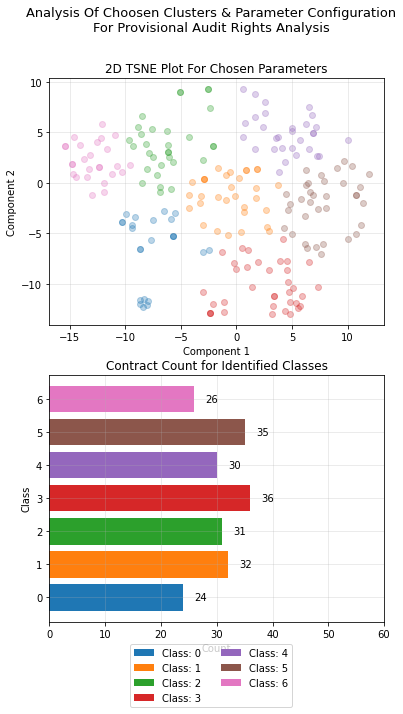

In [13]:
#Extract labels for chosen parameters
labs = clustering[(choosen_params,choosen_k)].labels_

#Determine label counts in clustered classes
classes,counts = np.unique(labs,return_counts=True)


#Plot Results
fig, axs = plt.subplots(2, 1, figsize = (6,10))

#Plot TSNE representation for chosen parameters
X = TSNE_representations[choosen_params]
for l in np.unique(labs):
    idx = labs == l
    c_idx = classes == l
    axs[0].scatter(X[:,0][idx],X[:,1][idx],alpha = 0.3, label = 'Class: {}'.format(l))
    axs[1].barh(classes[c_idx],counts[c_idx], label = 'Class: {}'.format(l))

#Format Plot
axs[0].set_title('2D TSNE Plot For Chosen Parameters')
axs[0].set_xlabel('Component 1')
axs[0].set_ylabel('Component 2')
axs[0].grid(alpha = 0.3)


axs[1].set_title('Contract Count for Identified Classes')
axs[1].grid(alpha = 0.3)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Class')
axs[1].set_xlim([0,60])

for i, v in enumerate(counts):
    axs[1].text(v+2,i,str(v),va='center', color='black')

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center', ncol = 2,bbox_to_anchor = (0.5,-0))

plt.suptitle('Analysis Of Choosen Clusters & Parameter Configuration\nFor Provisional Audit Rights Analysis',size=13)
plt.show()

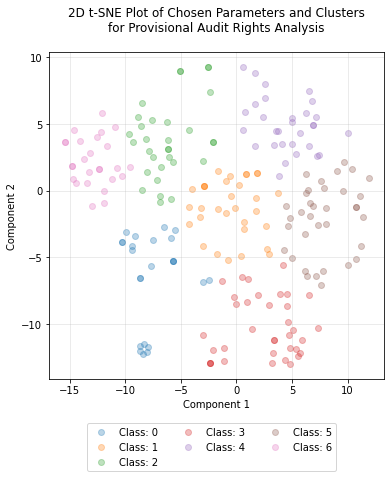

In [14]:
#Extract labels for chosen parameters
labs = clustering[(choosen_params,choosen_k)].labels_

#Determine label counts in clustered classes
classes,counts = np.unique(labs,return_counts=True)


#Plot Results
fig, axs = plt.subplots(figsize = (6,6))

#Plot TSNE representation for chosen parameters
X = TSNE_representations[choosen_params]
for l in np.unique(labs):
    idx = labs == l
    c_idx = classes == l
    axs.scatter(X[:,0][idx],X[:,1][idx],alpha = 0.3, label = 'Class: {}'.format(l))

#Format Plot
axs.set_xlabel('Component 1')
axs.set_ylabel('Component 2')
axs.grid(alpha = 0.3)

fig.legend(loc='lower center', ncol = 3,bbox_to_anchor = (0.5,-0.1))
axs.set_title('2D t-SNE Plot of Chosen Parameters and Clusters\nfor Provisional Audit Rights Analysis\n',size=12)
plt.savefig('Fig14.png',bbox_inches='tight')
plt.show()

In [15]:
df = pd.DataFrame(label_cluster(GL_features,labs,3)).T
df.style.hide_index()

Class,Class Label,Token to Annotation Ratio
0,reasonable -- notice -- upon,1.625 -- 0.750 -- 0.542
1,agreement -- business -- upon,2.625 -- 1.438 -- 1.281
2,agreement -- inspection -- reasonable,2.000 -- 1.548 -- 1.516
3,time -- reasonable -- inspect,2.167 -- 0.944 -- 0.917
4,business -- reasonable -- notice,1.433 -- 1.367 -- 1.133
5,business -- may -- hours,2.057 -- 1.486 -- 1.200
6,inspection -- reasonable -- notice,1.885 -- 1.731 -- 0.846


In [16]:
print('vocabulary used in the vectorization with choosen parameters:\n')

for v in vocab[choosen_params].keys():
    print(v)

vocabulary used in the vectorization with choosen parameters:

may
agreement
normal
business
hours
upon
reasonable
notice
time
inspection


### Section 3.3: Applying Specialist Knowledge (Hand Crafted Features) and KMeans Clustering

This investigates the application of simple NLP techniques combined with specialist legal knowledge to the clause text

In [17]:
#Import packages required for the section
import spacy
from spacy import displacy
import en_core_web_sm
import geonamescache
import pandas as pd
import truecase
import re

In [18]:
#Reset clause extraction to allow for differing pre processing needs
clean = clean_clause(punct=False,
                     lower=False,
                     stop_wd = False,
                     double_spaces= True,
                     strip=True)

AR_features = clean.fit_transform(combined_annotations_GL)

In [19]:
#Define words of interest list for analysis
words_of_iterest = ['cost','notice']

#load nlp model
nlp = en_core_web_sm.load()

#Build new features
new_features = []
not_mapped = []

#For each annotation in the features
for annotation in AR_features:
    #Initate list of new features for annotation
    annotation_GPEs = []
    
    #Force correct capitalisation on annotation
    annotation = truecase.get_true_case(annotation)
    
    #Build the document for analysis
    doc = nlp(repr(annotation))
    
    #Initate list for storing neewly identified features in annotation/doc
    doc_feature_list = []   
    
    #For each token in the annotation/doc
    for token in doc:
        
        #if the token is either 'cost' or 'notice'
        if token.text.lower() in words_of_iterest:
            
            #Add the token to the new doc_feature_list
            doc_feature_list.append(token.text)
            
            #Identify and add the syntactic children of the token and add to doc_feature_list
            for w in token.children:
                doc_feature_list.append(w.text)         
    
    #Concatinate doc_feature_list to a string and append to new_features
    new_features.append(' '.join(doc_feature_list))

In [20]:
#Count number of annotations where a GPE or LANGUAGE has not been extracted
not_mapped_count = list(map(lambda x : 1 if x == '' else 0, new_features))

#Output mapping analysis
print('{} out of {} not mapped via process ({:.2%})'.format(*(sum(not_mapped_count),len(not_mapped_count),
                                                              sum(not_mapped_count)/len(not_mapped_count))))

75 out of 214 not mapped via process (35.05%)


In [21]:
for i in range(len(new_features)):
    if new_features[i] == '':
        new_features[i] = 'nomatch'

In [22]:
#Count number of annotations where a GPE or LANGUAGE has not been extracted
not_mapped_count = list(map(lambda x : 1 if x == '' else 0, new_features))

#Output mapping analysis
print('{} out of {} not mapped via process ({:.2%})'.format(*(sum(not_mapped_count),len(not_mapped_count),
                                                              sum(not_mapped_count)/len(not_mapped_count))))

0 out of 214 not mapped via process (0.00%)


In [23]:
#initate clause_clean class with paramaters set for specific problem
clean = clean_clause(punct=True,
                     lower=True,
                     stop_wd = True,
                     double_spaces= True,
                     strip=True,
                     additional_stop_words = additional_stop_words)

new_features = clean.fit_transform(new_features)

#Additional pass to remove double spacing
#new_features = np.array(list(map(lambda x: re.sub('\\t|\\r|\\n|[^\S]{2,}',' ',x),new_features)))

In [24]:
#Initate dictionary to hold multiple vector representations
vector_representations_NER = {}
TSNE_representations_NER = {}
vocab_NER = {}

#Define range of n_grams to investigate
n_gram_rng =[(1,1),(1,2)]
vectorisation_technique =['TfIdf']
max_features_rng = [10,15,20,None]

for approach in vectorisation_technique:
    for n_gram in n_gram_rng:
        for feats in max_features_rng:
        
            vect_method = {'count':CountVectorizer(ngram_range = n_gram,max_features = feats),
                           'TfIdf':TfidfVectorizer(ngram_range = n_gram,max_features = feats)}

            vectorizer = vect_method[approach]
            
            
            vector_representations_NER[(approach,n_gram,feats)] = vectorizer.fit_transform(new_features).toarray()
            TSNE_representations_NER[(approach,n_gram,feats)] = TSNE(n_components=2,random_state = 42).fit_transform(vector_representations_NER[(approach,n_gram,feats)])
            
            vocab_NER[(approach,n_gram,feats)] = vectorizer.vocabulary_
        

In [25]:
#Initate dictionaries to store results in a list
results_NER = defaultdict(list)
score_NER = defaultdict(list)
clustering_NER = {}


for key in TSNE_representations_NER.keys():
    for k in k_rng:
        cluster = KMeans(n_clusters=k, random_state=42).fit(TSNE_representations_NER[key])
        
        #Append results for respective k to results and score lists dictionaries with given key
        results_NER[key].append(cluster.inertia_)
        score_NER[key].append(S_Dbw(TSNE_representations_NER[key], cluster.labels_, centers_id=None, 
                                method='Tong', alg_noise='bind',
                                centr='mean', nearest_centr=True,
                                metric='euclidean'))

        clustering_NER[(key,k)] = cluster

In [26]:
#Select Choosen Parameters
choosen_params_NER =('TfIdf',(1,2),10)
choosen_k_NER = 6

#Extract choosen plot values
x_k = choosen_k_NER
y_sse = np.array(results_NER[choosen_params_NER])[k_rng == choosen_k_NER][0]
y_sdbw = np.array(score_NER[choosen_params_NER])[k_rng == choosen_k_NER][0]

In [27]:
print('SSE score for optimal paramaters: {:.2f}'.format(y_sse))
print('S-DBW score for optimal paramaters: {:.2f}'.format(y_sdbw))

SSE score for optimal paramaters: 372.52
S-DBW score for optimal paramaters: 0.06


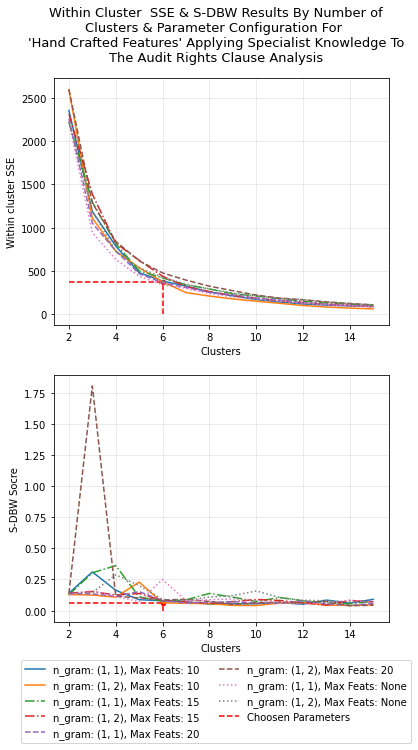

In [28]:
#Plot Results
fig, axs = plt.subplots(2, 1, figsize = (6,10))

lin_type = dict(zip(max_features_rng, ['-','-.','--',':']))

for i in range(len(max_features_rng)):
    
    feats_to_plot = max_features_rng[i]
    
    for key in results_NER.keys():
        if key[2] == feats_to_plot:
            
            axs[0].plot(k_rng, results_NER[key],
                        label = 'n_gram: {1}, Max Feats: {2}'.format(*key),
                        linestyle = lin_type[feats_to_plot])
            
            axs[1].plot(k_rng, score_NER[key],
                        label = 'n_gram: {1}, Max Feats: {2}'.format(*key),
                        linestyle = lin_type[feats_to_plot])
            
#Add chosen parmater call out to plot 0            
axs[0].scatter(x_k,y_sse,color = 'red',s = 20)
axs[0].vlines(x_k,ymin = 0, ymax = y_sse,color='red',linestyle='--',label ='Choosen Parameters')
axs[0].hlines(y_sse,xmin = 2, xmax = x_k,color='red',linestyle='--')

#Add chosen parmater call out to plot 1
axs[1].scatter(x_k,y_sdbw,color = 'red',s = 20)
axs[1].vlines(x_k,ymin = 0, ymax = y_sdbw,color='red',linestyle='--',label ='Choosen value')
axs[1].hlines(y_sdbw,xmin = 2, xmax = x_k,color='red',linestyle='--')

#format axs[0]            
axs[0].grid(alpha = 0.3)
axs[0].set_xlabel('Clusters')
axs[0].set_ylabel('Within cluster SSE')

axs[1].grid(alpha = 0.3)
axs[1].set_xlabel('Clusters')
axs[1].set_ylabel('S-DBW Socre')

fig.suptitle('Within Cluster  SSE & S-DBW Results By Number of\nClusters & Parameter Configuration For \n\'Hand Crafted Features\' Applying Specialist Knowledge To\nThe Audit Rights Clause Analysis',size = 13)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center', ncol = 2,bbox_to_anchor = (0.5,-0.05))
plt.savefig('Fig15.png',bbox_inches='tight')
plt.show()

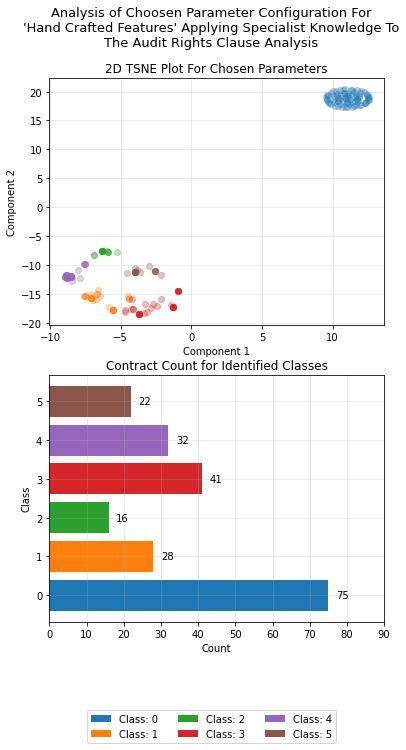

In [29]:
#Extract labels for chosen parameters
labs = clustering_NER[(choosen_params_NER,choosen_k_NER)].labels_

#Determine label counts in clustered classes
classes,counts = np.unique(labs,return_counts=True)


#Plot Results
fig, axs = plt.subplots(2, 1, figsize = (6,10))

#Plot TSNE representation for chosen parameters
X = TSNE_representations_NER[choosen_params_NER]
for l in np.unique(labs):
    idx = labs == l
    c_idx = classes == l
    axs[0].scatter(X[:,0][idx],X[:,1][idx],alpha = 0.3, label = 'Class: {}'.format(l))
    axs[1].barh(classes[c_idx],counts[c_idx], label = 'Class: {}'.format(l))

#Format Plot
axs[0].set_title('2D TSNE Plot For Chosen Parameters')
axs[0].set_xlabel('Component 1')
axs[0].set_ylabel('Component 2')
axs[0].grid(alpha = 0.3)


axs[1].set_title('Contract Count for Identified Classes')
axs[1].grid(alpha = 0.3)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Class')
axs[1].set_yticks(classes)
axs[1].set_xlim([0,90])

for i, v in enumerate(counts):
    axs[1].text(v+2,i,str(v),va='center', color='black')

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center', ncol = 3,bbox_to_anchor = (0.5,-0.05))

plt.suptitle('Analysis of Choosen Parameter Configuration For\n\'Hand Crafted Features\' Applying Specialist Knowledge To\nThe Audit Rights Clause Analysis',size=13)
plt.show()

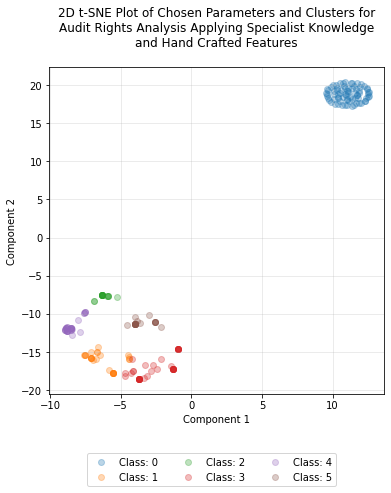

In [30]:
#Extract labels for chosen parameters
labs = clustering_NER[(choosen_params_NER,choosen_k_NER)].labels_

#Determine label counts in clustered classes
classes,counts = np.unique(labs,return_counts=True)


#Plot Results
fig, axs = plt.subplots(figsize = (6,6))

#Plot TSNE representation for chosen parameters
X = TSNE_representations_NER[choosen_params_NER]
for l in np.unique(labs):
    idx = labs == l
    c_idx = classes == l
    axs.scatter(X[:,0][idx],X[:,1][idx],alpha = 0.3, label = 'Class: {}'.format(l))
    
#Format Plot
axs.set_xlabel('Component 1')
axs.set_ylabel('Component 2')
axs.grid(alpha = 0.3)


fig.legend(loc='lower center', ncol = 3,bbox_to_anchor = (0.5,-0.1))
axs.set_title('2D t-SNE Plot of Chosen Parameters and Clusters for\nAudit Rights Analysis Applying Specialist Knowledge\nand Hand Crafted Features\n',size=12)

plt.savefig('Fig16.png',bbox_inches='tight')
plt.show()

In [31]:
cluster_summary(counts)

Minimum cluster contract count is: 16
Maximum cluster contract count is: 75
Mean cluster contract count is: 35.67
Variance of cluster contract count is: 19.24


In [32]:
counts

array([75, 28, 16, 41, 32, 22], dtype=int64)

In [33]:
df = pd.DataFrame(label_cluster(new_features,labs,3)).T
df.style.hide_index()

Class,Class Label,Token to Annotation Ratio
0,nomatch,1.000
1,notice -- reasonable -- prior,1.500 -- 1.214 -- 1.214
2,cost -- notice -- expense,1.375 -- 0.312 -- 0.188
3,notice -- written -- prior,1.829 -- 1.146 -- 0.805
4,notice -- reasonable -- cost,1.312 -- 1.281 -- 0.219
5,notice -- advance -- reasonable,1.455 -- 1.273 -- 0.909


In [34]:
print('vocabulary used in the vectorization with choosen parameters:\n')

for v in vocab_NER[choosen_params_NER].keys():
    print(v)

vocabulary used in the vectorization with choosen parameters:

nomatch
notice
reasonable
prior
notice reasonable
reasonable prior
cost
advance
written
prior written


### Section 3.3 Random Samples for Appendicies

In [35]:
#print random samples from class 1
print_samples(combined_annotations_GL[labs == 0],5)

5 Random samples from the data:

The Fund shall also furnish Integrity upon request with: (a) annual audits of the Fund's books and accounts made by independent public accountants regularly retained by the Fund, (b) semi-annual unaudited financial statements pertaining to the Fund, (c) quarterly earnings statements prepared by the Fund, (d) a monthly itemized list of the securities in the portfolio of the Fund, (e) monthly balance sheets as soon as practicable after the end of each month, and (f) from time to time such additional information regarding the Fund's financial condition as Integrity may reasonably request. 

All books of account and records of Licensee covering all transactions relating to the Licensee shall be retained by the Licensee until at least two (2) years after the expiration or termination of the Term for possible inspection by Smith. Smith shall have the right to engage an independent accounting firm to examine the Licensee's sales information and all other books

In [36]:
#print random samples from class 1
print_samples(combined_annotations_GL[labs == 1],5)

5 Random samples from the data:

Upon completion of such inspection, PPI shall not be entitled to inspect nor shall EKR be required to make available the records and books for any Calendar Year for which such inspection was previously undertaken. and books referred to in Section 7.2. EKR shall during business hours, on no less than 14 day's notice from PPI and not more than once in any Calendar Year, make available for inspection the records Such inspection shall be undertaken by an independent auditor appointed by PPI and reasonably acceptable to EKR for the purpose of verifying the accuracy of any statement or report given by EKR to PPI and/or the amount of Royalties due. (b) from time to time consult with PPI's representatives for the purpose of assessing the state of the market in each country of the Territory and permit representatives of PPI, on reasonable prior notice, to inspect any premises or documents used in connection with the marketing, distribution and sale of the Produc